In [44]:
import sys

In [45]:
sys.path.append("/Volumes/hauptjoh.hub/utils")

In [46]:
import data_loader
import numpy as np
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import cross_validate, RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score, make_scorer

from sklearn.datasets import make_classification

import matplotlib.pyplot as plt
import seaborn as sns

Load data of DMC 20015 and clean it

In [47]:
X,y = data_loader.load_dmc05("/Volumes/hauptjoh.hub/data")

Collect the indices of continuous and categorical columns for preprocessing through sklearn's ColumnTransformer. 

In [48]:
# Initialize index lists
idx_cont = None
idx_cat  = None

if idx_cat is None:
    idx_cat = list(np.where(X.dtypes=='category')[0])
    idx_cat = [int(x) for x in idx_cat]

if idx_cont is None:
    idx_cont = [x for x in range(X.shape[1]) if x not in idx_cat]
    idx_cont = [int(x) for x in idx_cont]

# Initialize embedding tuples
categorical = None
if idx_cat is not None:
    categorical = [(i,
                    len(X.iloc[:,i].cat.categories),
                    int(min(15., np.ceil(0.5*len(X.iloc[:,i].cat.categories))))
                   )
                    for i in idx_cat]


# Make sure categorical variables are encoded from 0
if np.any([idx>min(idx_cat) for idx in idx_cont]):
    raise ValueError("Variables need to be ordered [cont, cat]")


X=X.to_numpy(dtype=np.float32)
y=y.to_numpy(dtype=np.int32)

In [49]:
X = X[np.argsort(y),:][-12051:-51]

In [50]:
y = y[np.argsort(y)][-12051:-51]

In [51]:
np.mean(y)

0.14125

Data Dimensionality

In [52]:
X.shape

(12000, 32)

In [53]:
len(idx_cont)

5

In [54]:
len(categorical)

27

In [55]:
sum([i for _,i,_ in categorical])

651

## Select appropriate model pipeline

In [81]:
preproc = StandardScaler()
model = LogisticRegression(C=25, solver='lbfgs', max_iter=1000)

pipeline = Pipeline(steps=[
    ('preproc', preproc),
    ('classifier', model)
  ])


In [76]:
preproc_sampler = ColumnTransformer([
        ('scaler', MinMaxScaler(), idx_cont),
        ('pass',   'passthrough',  idx_cat)
    ])

preproc_clf = ColumnTransformer([
    ('pass', 'passthrough', idx_cont),
    ('ohe',   OneHotEncoder(categories='auto', handle_unknown='ignore'),  idx_cat)
])


model = LogisticRegression(C=100, solver='saga', max_iter=1000)
    
pipeline = Pipeline(steps=[
    ('preproc_sampler', preproc_sampler),
    ('preproc_clf', preproc_clf),
    ('classifier', model)
  ])


## Specify imbalance ratios to be tested

In [83]:
#imb_ratio = [1,2,3,4,5,10,20,50]
imb_ratio = [(0.5+e, round(0.5-e, 3) ) for e in [0,0.1,0.2,0.3,0.40,0.450,0.49,0.499] ]
ratio_minority = {}
perf = {}

In [84]:
imb_ratio

[(0.5, 0.5),
 (0.6, 0.4),
 (0.7, 0.3),
 (0.8, 0.2),
 (0.9, 0.1),
 (0.95, 0.05),
 (0.99, 0.01),
 (0.999, 0.001)]

## Effect of imbalance I: Constant no. of majority, increasing sparcity of minority cases

In [129]:
N_SAMPLES = int(1e4)
N_FEATURES = 20

In [130]:
for ratio in imb_ratio:
    X_temp, y_temp  = make_classification(n_samples=N_SAMPLES, n_features=N_FEATURES, 
                                          n_informative=N_FEATURES//2, 
                                          n_clusters_per_class=4, class_sep=1,
                                 weights=ratio, random_state=123) 
    ratio_minority[ratio] = y_temp.mean()
    
    perf[ratio] =  cross_validate(pipeline,X=X_temp,y=y_temp,
                            cv=RepeatedStratifiedKFold(n_repeats = 20, n_splits=2, random_state=123), 
                            scoring=make_scorer(roc_auc_score, needs_proba=True), 
                            verbose=1, error_score='raise', return_train_score=False,
                                 n_jobs=3)


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  40 out of  40 | elapsed:    1.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  40 out of  40 | elapsed:    1.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  40 out of  40 | elapsed:    1.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  40 out of  40 | elapsed:    1.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  40 out of  40 | elapsed:    1.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  40 out of  40 | elapsed:    1.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  40 out of  40 | elapsed:   

In [131]:
for r,p in perf.items():
    print(r,p["test_score"].mean(), p["test_score"].std())
    
perf_mean_sd = np.array([(p["test_score"].mean(), p["test_score"].std()) for r,p in perf.items()])

(0.5, 0.5) 0.8751155284186398 0.0031909694941623283
(0.6, 0.4) 0.8742740478210951 0.002979240393098235
(0.7, 0.3) 0.8705966955966218 0.0030016341736739255
(0.8, 0.2) 0.8679312024562595 0.005111432346350818
(0.9, 0.1) 0.8524571416333394 0.005615519864538617
(0.95, 0.05) 0.8234912100923557 0.01193509408814945
(0.99, 0.01) 0.7057654107014253 0.026769761426148526
(0.999, 0.001) 0.5012225180077051 0.030655915301967866


In [132]:
for r,p in ratio_minority.items():
    print(r,p)

(0.5, 0.5) 0.5009
(0.6, 0.4) 0.402
(0.7, 0.3) 0.3033
(0.8, 0.2) 0.2041
(0.9, 0.1) 0.1049
(0.95, 0.05) 0.0551
(0.99, 0.01) 0.0154
(0.999, 0.001) 0.0063


<ErrorbarContainer object of 3 artists>

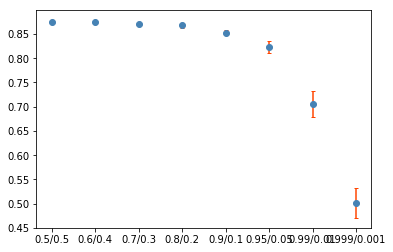

In [133]:
plt.errorbar([str(x)+'/'+str(y) for x,y in imb_ratio], 
             perf_mean_sd[:,0], yerr=perf_mean_sd[:,1], fmt='o', ecolor='orangered',
            color='steelblue', capsize=2)

## Effect of imbalance I: Increasing no. of majority cases, constant no. of minority cases

In [134]:
N_SAMPLES = int(1e4) # const. Minority cases: N_SAMPLES/2
N_FEATURES = 20

In [135]:
for ratio in imb_ratio:
    X_temp, y_temp  = make_classification(n_samples=int(N_SAMPLES/(2*ratio[1])), n_features=N_FEATURES, 
                                          n_informative=N_FEATURES//2, 
                                          n_clusters_per_class=4, class_sep=1,
                                 weights=ratio, random_state=123) 
    ratio_minority[ratio] = y_temp.mean()
    
    perf[ratio] =  cross_validate(pipeline,X=X_temp,y=y_temp,
                            cv=RepeatedStratifiedKFold(n_repeats = 100, n_splits=2, random_state=123), 
                            scoring=make_scorer(roc_auc_score, needs_proba=True), 
                            verbose=1, error_score='raise', return_train_score=False,
                                 n_jobs=3)


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  82 tasks      | elapsed:    3.9s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    9.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  82 tasks      | elapsed:    4.1s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    9.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    2.5s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    9.9s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:   10.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  81 tasks      | elapsed:    4.1s
[Parallel(n_jobs=3)]: Done 195 out of 200 | elapsed:    9.8s remaining:    0.3s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:   10.1s finished
[Parallel(n_jobs=3)]: Using backend

In [125]:
for r,p in perf.items():
    print(r,p["test_score"].mean(), p["test_score"].std())
    
perf_mean_sd = np.array([(p["test_score"].mean(), p["test_score"].std()) for r,p in perf.items()])

(0.5, 0.5) 0.875111386244093 0.003176053094366765
(0.6, 0.4) 0.8741733498061532 0.0034053301237005644
(0.7, 0.3) 0.8701544189219856 0.0036704801959633287
(0.8, 0.2) 0.8681966943859551 0.004821401861788071
(0.9, 0.1) 0.8522402200909005 0.006804896215540565
(0.95, 0.05) 0.823426074915425 0.010951731438031726
(0.99, 0.01) 0.7034597080757959 0.027396669198679054
(0.999, 0.001) 0.49826471626160007 0.0373839763825909


In [126]:
for r,p in ratio_minority.items():
    print(r,p)

(0.5, 0.5) 0.5009
(0.6, 0.4) 0.402
(0.7, 0.3) 0.3033
(0.8, 0.2) 0.2041
(0.9, 0.1) 0.1049
(0.95, 0.05) 0.0551
(0.99, 0.01) 0.0154
(0.999, 0.001) 0.0063


<ErrorbarContainer object of 3 artists>

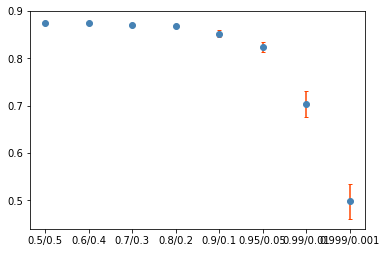

In [127]:
plt.errorbar([str(x)+'/'+str(y) for x,y in imb_ratio], 
             perf_mean_sd[:,0], yerr=perf_mean_sd[:,1], fmt='o', ecolor='orangered',
            color='steelblue', capsize=2)

## Old

In [ ]:
imb_ratio = [1,2,3,4,5,10,20,50]
ratio_minority = {}
perf = {}

In [ ]:
for ratio in imb_ratio:
    X_temp = X[:y.sum()+int(y.sum()/ratio)]
    y_temp = y[:y.sum()+int(y.sum()/ratio)]
    ratio_minority[ratio] = y_temp.mean()
    
    perf[ratio] =  cross_validate(pipeline,X=X_temp,y=y_temp,
                            cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=123), 
                            scoring=make_scorer(roc_auc_score, needs_proba=True), 
                            verbose=1, error_score='raise', return_train_score=False)


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
for r,p in perf.items():
    print(r,p["test_score"])

In [ ]:
for r,p in perf.items():
    print(r,p["test_score"].mean(), p["test_score"].std())

In [ ]:
for r,p in ratio_minority.items():
    print(r,p)